In [1]:
import tqdm
import tqdm.notebook as tq
import matplotlib.pyplot as plt
import numpy as np
import torch

import sys
import os
prj_root = os.path.join( os.path.abspath(""), '..', '..' )
print(f"{prj_root =}")
sys.path.append(prj_root) # root folder for the project

prj_root ='/home/zetadin/Projects/TerrainDiffusion/src/Training/../..'


# Load training data

In [42]:
from src.DataSet.DataSet import TiledDataset
from torchvision.transforms import v2

# create a dataset from the test data
ds = TiledDataset(
                  os.path.join(prj_root , "Data" ),
                  # os.path.join(prj_root , "tests", "test_Data" ),
                  tile_size=256, rotations=[0,15,30,45],
                  transform = v2.Compose([
                        v2.RandomHorizontalFlip(),
                        v2.RandomVerticalFlip(),
                        v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
                    ]))

print("Dataset size:", len(ds))

# get a batch of all the tiles and figure out the mean and standard deviation
dataloader = torch.utils.data.DataLoader(ds, batch_size=len(ds), shuffle=False)
all_tiles = next(iter(dataloader))
mean = torch.mean(all_tiles).item()
std = torch.std(all_tiles).item()

print(f"{mean=}")
print(f"{std=}")
print(f"min={torch.min(all_tiles)}")
print(f"max={torch.max(all_tiles)}")

# what should the std be?
target_std = 0.5

# add a Normalize transform for production ready data
ds.transform = v2.Compose([
                        v2.RandomHorizontalFlip(),
                        v2.RandomVerticalFlip(),
                        v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
                        v2.Normalize(mean=[mean], std=[std/target_std]),
                    ])

# rebuild dataloader and resample the data
dataloader = torch.utils.data.DataLoader(ds, batch_size=len(ds), shuffle=True)

Tiling Mongolia.png_45: 100%|███████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.79it/s]


Freeing alpha channels.
Garbage collected 69747 objects.
Dataset size: 10821
mean=0.2560078799724579
std=0.2166047841310501
min=0.0
max=1.0


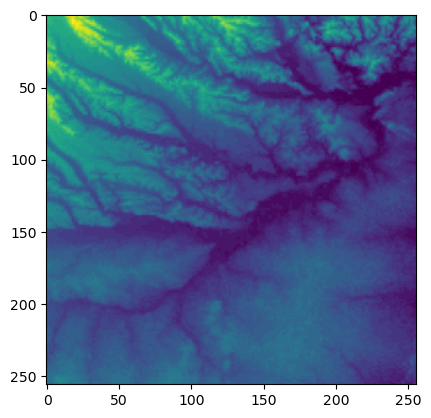

In [3]:
plt.imshow(ds[1][0,:,:])
plt.show()

In [4]:
invTrans = v2.Compose([
    v2.Normalize(mean = [0.], std = [target_std/std]), v2.Normalize(mean = [-mean], std=[1.])
])

# Subclass diffusers.DDPMScheduler to be able to predict original image from modeled noise in one go during validation

In [5]:
from diffusers import DDPMScheduler
# import inspect
# print(inspect.getfile(DDPMScheduler))

class MyDDPMSCheduler(DDPMScheduler):
    def match_shape(self,
                    values: "Union[np.ndarray, torch.Tensor]",
                    broadcast_array: "Union[np.ndarray, torch.Tensor]"):
        """
        Turns a 1-D array into an array or tensor with len(broadcast_array.shape) dims.

        Args:
            values: an array or tensor of values to extract.
            broadcast_array: an array with a larger shape of K dimensions with the batch
                dimension equal to the length of timesteps.
        Returns:
            a tensor of shape [batch_size, 1, ...] where the shape has K dims.
        """

        tensor_format = getattr(self, "tensor_format", "pt")
        values = values.flatten()

        while len(values.shape) < len(broadcast_array.shape):
            values = values[..., None]
        if tensor_format == "pt":
            values = values.to(broadcast_array.device)

        return values
        
    def single_iter_predict_original(self,
        model_output: "Union[torch.FloatTensor, np.ndarray]",
        timesteps: "Union[torch.IntTensor, np.ndarray]",
        sample: "Union[torch.FloatTensor, np.ndarray]",
        predict_epsilon=True,) -> torch.FloatTensor:

        # t = timesteps

        if model_output.shape[1] == sample.shape[1] * 2 and self.variance_type in ["learned", "learned_range"]:
            model_output, predicted_variance = torch.split(model_output, sample.shape[1], dim=1)
        else:
            predicted_variance = None


        # 1. compute alphas, betas
        # alpha_prod_t = self.alphas_cumprod[t]
        # beta_prod_t = 1 - alpha_prod_t

        sqrt_alpha_prod = self.alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = self.match_shape(sqrt_alpha_prod, sample)
        sqrt_one_minus_alpha_prod = (1 - self.alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = self.match_shape(sqrt_one_minus_alpha_prod, sample)

        # print(f"{t.shape=}")
        # print(f"{beta_prod_t.shape=}")
        # print(f"{sample.shape=}")
        # print(f"{model_output.shape=}")

        # 2. compute predicted original sample from predicted noise also called
        # "predicted x_0" of formula (15) from https://arxiv.org/pdf/2006.11239.pdf
        if predict_epsilon:
            pred_original_sample = (sample - sqrt_one_minus_alpha_prod * model_output) / sqrt_alpha_prod
        else:
            pred_original_sample = model_output

        return(pred_original_sample)

# Create Lightning wrapper around a model

In [6]:
import lightning as L
import torchmetrics
import torchvision
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.utils import make_image_grid
from torch import nn

class TerGenUNet(L.LightningModule):
    def __init__(self, tile_size=256,  n_inferences=25, n_iter_train=1000,
                 down_block_types=(
                    "DownBlock2D",  # a regular ResNet downsampling block
                    "DownBlock2D",
                    "DownBlock2D",
                    "DownBlock2D",
                    "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                    "DownBlock2D",
                    ),
                 up_block_types=(
                    "UpBlock2D",  # a regular ResNet upsampling block
                    "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                    "UpBlock2D",
                    "UpBlock2D",
                    "UpBlock2D",
                    "UpBlock2D",
                    ),
                 block_out_channels=(64, 64, 128, 128, 256, 256), # the number of output channels for each UNet block
                 norm_num_groups=32,
                 attention_head_dim=8,
                 ls_scheduler_settings = {"base_lr":5e-5, "max_lr":1e-3,
                                          "step_size_up":20}
                ):
        super().__init__()
        self.save_hyperparameters()

        self.n_inferences = n_inferences
        self.n_iter_train = n_iter_train
        self.ls_scheduler_settings = ls_scheduler_settings
        self.tile_size = tile_size


        # metrics
        self.train_MSE = torchmetrics.regression.MeanSquaredError()
        self.val_MSE = torchmetrics.regression.MeanSquaredError()

        # UNet
        self.unet = UNet2DModel(
            sample_size=tile_size,
            in_channels=1, out_channels=1,  # the number of I/O channels: monochrome
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels = block_out_channels, 
            down_block_types = down_block_types,
            up_block_types = up_block_types,
            norm_num_groups = norm_num_groups,
            attention_head_dim = attention_head_dim
        )

        # noise scheduler & pipelines
        # self.noise_scheduler = DDPMScheduler(num_train_timesteps=self.n_inferences)
        self.noise_scheduler = MyDDPMSCheduler(num_train_timesteps=self.n_iter_train)


    def forward(self, noised, inference_amounts):
        """Perform a sequence of inferences on the noise."""
        o = self.unet(noised, inference_amounts).sample
        return o
           

    def training_step(self, inp, batch_idx):
        """Execute a step of training."""
        with torch.no_grad(): # no need for gradients on input data
            bs = inp.shape[0]
            noise = torch.randn(inp.shape, device = inp.device)
    
            # random number of inferences to perform on each image
            inference_amounts = torch.randint(0, self.n_iter_train, (bs,),
                                     device=inp.device, dtype=torch.int64)
            
            noised_inp = self.noise_scheduler.add_noise(inp, noise, inference_amounts)

        out = self.forward(noised_inp, inference_amounts)
        
        # compute and log loss
        loss = nn.functional.mse_loss(noise,out)
        self.log('loss', loss)

        # compute metrics
        self.train_MSE(noise,out)

        return loss
        
        
    def on_train_epoch_end(self):
        # log epoch metrics
        self.log('train_MSE_epoch', self.train_MSE.compute())
        self.train_MSE.reset()
        
    
    def sample(self, N, seed = None, n_inference_iter=None, use_default_gen=False):
        """
        Generate some images.
        """
        with torch.no_grad():
            if(not use_default_gen):
                gen = torch.Generator(device = self.device)
                if(seed is not None):
                    gen.manual_seed(seed)
            else:
                gen=None

            if(n_inference_iter is None):
                n_inference_iter = self.n_inferences

            # next part adapted from DDPMPipeline to output raw tensors, not normalized PILs or ndarrays
            # Sample gaussian noise to begin loop
            images = torch.randn((N, 1, self.tile_size, self.tile_size),
                                 generator=gen, device = self.device)    
            # set step values
            self.noise_scheduler.set_timesteps(n_inference_iter)
    
            for t in self.noise_scheduler.timesteps:
                # 1. predict noise model_output
                model_output = self.unet(images, t).sample
    
                # 2. compute previous image: x_t -> t_t-1
                images = self.noise_scheduler.step(model_output, t, images, generator=gen).prev_sample
        return(images)
        

    def validation_step(self, inp):
        # this is the validation loop
        with torch.no_grad(): # no need for gradients on input data
            bs = inp.shape[0]
            noise = torch.randn(inp.shape, device = inp.device)
    
            # random number of inferences to perform on each image
            inference_amounts = torch.randint(0, self.n_iter_train, (bs,),
                                     device=inp.device, dtype=torch.int64)
            
            noised_inp = self.noise_scheduler.add_noise(inp, noise, inference_amounts)

            out = self.forward(noised_inp, inference_amounts)
        
            # compute metrics
            self.val_MSE(noise,out)
            
    
    def on_validation_epoch_end (self):
        # log epoch metrics
        self.log('val_MSE_epoch', self.val_MSE.compute())
        self.val_MSE.reset()

        # print(f"Epoch {self.trainer.current_epoch} ended validation.")
        if(self.trainer.current_epoch%10 == 0 
           # and self.trainer.current_epoch > 0
          ):
            outs = invTrans(self.sample(4, seed=268711))
            images = [v2.functional.to_pil_image(outs[i,:,:]) for i in range(outs.shape[0])]
            image_grid = make_image_grid(images, rows=2, cols=2)

            # Save some sample images
            test_dir = os.path.join(self.trainer.logger.log_dir, "samples")
            # print(f"Epoch {self.trainer.current_epoch}: saving samples to {test_dir}/{self.trainer.current_epoch:06d}.png")
            os.makedirs(test_dir, exist_ok=True)
            image_grid.save(os.path.join(test_dir, f"gen_{self.trainer.current_epoch:06d}.png"))
                        
            
            # also draw validation set examples
            inp = next(iter(self.trainer.val_dataloaders)).to(self.device)
            bs = inp.shape[0]
            noise = torch.randn(inp.shape, device = inp.device)
            # random number of inferences to perform on each image
            inference_amounts = torch.randint(0, self.n_iter_train, (bs,),
                                     device=inp.device, dtype=torch.int64)
            noised_inp = self.noise_scheduler.add_noise(inp, noise, inference_amounts)
            out = self.forward(noised_inp, inference_amounts)

            pred_original = self.noise_scheduler.single_iter_predict_original(out, inference_amounts, noised_inp)

            # inp_imgs = [v2.functional.to_pil_image(invTrans(inp[i,:,:])) for i in range(bs)]
            # noised_imgs = [v2.functional.to_pil_image(invTrans(noised_inp[i,:,:])) for i in range(bs)]
            # out_imgs = [v2.functional.to_pil_image(invTrans(out[i,:,:])) for i in range(bs)]
            # imgs = noised_imgs + inp_imgs + out_imgs
            # pil_image_grid = make_image_grid(imgs, rows=3, cols=bs)
            # pil_image_grid.save(os.path.join(test_dir, f"val_{self.trainer.current_epoch:06d}.png"))
            
            # log them to TensorBoard instead
            imgs_tensor = torch.cat([invTrans(noised_inp), invTrans(inp), invTrans(pred_original)])
            tv_image_grid = torchvision.utils.make_grid(imgs_tensor, nrow=bs)
            self.logger.experiment.add_image('validation_images', tv_image_grid, self.trainer.global_step, dataformats="CHW")
            
            

    
    def configure_optimizers(self):       
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-3)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": torch.optim.lr_scheduler.CyclicLR(
                                     optimizer,
                                     base_lr = self.ls_scheduler_settings["base_lr"],
                                     max_lr = self.ls_scheduler_settings["max_lr"],
                                     cycle_momentum=False, 
                                     step_size_up = self.ls_scheduler_settings["step_size_up"]),
                "interval": "epoch",
                "frequency": 1,
                "monitor": "train_MSE_epoch",
            },
        }

# Architecture definitions

In [7]:
UNetTiny_blocks = (
    (
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    (
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
    ),
    (32, 32, 32, 64)
)

UNetMini_blocks = (
    (
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    (
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    (32, 32, 32, 64, 64)
)

UNetSmall_blocks = (
    (
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    (
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    (32, 64, 64, 64, 128, 128)
)

# Do training

In [34]:
from lightning.pytorch.callbacks import TQDMProgressBar, LearningRateMonitor
from lightning.pytorch.callbacks import GradientAccumulationScheduler
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

def train(nEpochs=1000, nInfer=16, nTrainIter=1000, ls_scheduler_settings = None,
          # grad_batches=1,
          grad_accumulate_schedule = {0: 1, 100: 2, 150: 4},
          batch_size=8, blockSet=None, seed=59873):

    # trainer configs
    checkpoint_callback = ModelCheckpoint(monitor="val_MSE_epoch",
                                          filename='{epoch:06d}',
                                          save_top_k=5, every_n_epochs=5)
    # logger = TensorBoardLogger("tb_logs", name="debug_UNet_train2noise_1kTrainIter")
    logger = TensorBoardLogger("tb_logs", name="UNet_train2noise_1kTrainIter")
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    accumulator = GradientAccumulationScheduler(scheduling=grad_accumulate_schedule)
    trainer = L.Trainer(limit_train_batches=1.0,
                        max_epochs=nEpochs,
                        logger=logger,
                        log_every_n_steps=10,
                        accelerator="gpu",
                        check_val_every_n_epoch = 1,
                        # accumulate_grad_batches = grad_batches,
                        callbacks=[TQDMProgressBar(refresh_rate=batch_size), lr_monitor, checkpoint_callback, accumulator])
    
    print("batch_size:", batch_size)
    print("Logging to:", trainer.logger.log_dir)

    # reproducibility
    torch.manual_seed(seed)
    # torch.use_deterministic_algorithms(False)

    # dataloader
    g = torch.Generator()
    g.manual_seed(seed + 791423)
    train_dataset, val_dataset = torch.utils.data.random_split(ds, [0.8, 0.2], generator=g)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, generator=g, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, generator=g, shuffle=False)

    # create model
    if(blockSet is None):
        model = TerGenUNet(tile_size=256,  n_inferences=nInfer, n_iter_train=nTrainIter,
                           ls_scheduler_settings=ls_scheduler_settings)
    else:
        down_block_types, up_block_types, block_out_channels = blockSet
        model = TerGenUNet(tile_size=256,  n_inferences=nInfer, n_iter_train=nTrainIter,
                           down_block_types = down_block_types,
                           up_block_types=up_block_types,
                           block_out_channels = block_out_channels,
                           ls_scheduler_settings=ls_scheduler_settings)

    # run trainer
    trainer.fit(model, train_loader, val_loader)
    return(trainer.logger.log_dir)


# test the training
ls_scheduler_settings = {"base_lr":1e-5, "max_lr":3e-4, "step_size_up":25}
cur_log_folder = train(nEpochs=100, batch_size=8, nInfer=50, blockSet=UNetMini_blocks,
                       ls_scheduler_settings=ls_scheduler_settings,
                       grad_accumulate_schedule = {0: 1, 10: 2, 20: 4})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | train_MSE | MeanSquaredError | 0      | train
1 | val_MSE   | MeanSquaredError | 0      | train
2 | unet      | UNet2DModel      | 2.1 M  | train
-------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.244     Total estimated model params size (MB)
399       Modules in train mode
1         Modules in eval mode


batch_size: 8
Logging to: tb_logs/UNet_train2noise_1kTrainIter/version_0


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# Continue Training with different settings

In [75]:
from lightning.pytorch.callbacks import TQDMProgressBar, LearningRateMonitor
from lightning.pytorch.callbacks import GradientAccumulationScheduler
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.core.optimizer import _configure_schedulers_automatic_opt

class ReplaceLRSchedulerCallback(Callback):
    """
    Replaces the LRScheduler and LR after they were loaded from a checkpoint.
    """
    def __init__(self,
                 ls_scheduler_settings={"base_lr":5e-6, "max_lr":1e-5, "step_size_up":25},
                 lr=1e-5):
        self.replaced = False
        self.ls_scheduler_settings = ls_scheduler_settings
        self.lr = lr
        
        
    def on_train_epoch_start(self, trainer, pl_module):       
        if not self.replaced:
            # print("Original Optimizer and LR Scheduler:")
            # print(f"{trainer.strategy.lr_scheduler_configs[0].scheduler.__dict__=}")

            trainer.strategy.optimizers[0].lr = self.lr
            trainer.strategy.lr_scheduler_configs[0].scheduler.max_lrs = [self.ls_scheduler_settings["max_lr"]]
            trainer.strategy.lr_scheduler_configs[0].scheduler.base_lrs = [self.ls_scheduler_settings["base_lr"]]
            trainer.strategy.lr_scheduler_configs[0].scheduler.total_size = 2*self.ls_scheduler_settings["step_size_up"]
            trainer.strategy.lr_scheduler_configs[0].scheduler._last_lr = [self.lr]
           
            self.replaced = True

            # print("After replacement:")
            # print(f"{trainer.strategy.lr_scheduler_configs[0].scheduler.__dict__=}")



def continue_train( 
          chpt: str,
          nEpochs=1000, ls_scheduler_settings = None,
          grad_accumulate_schedule = {0: 1, 100: 2, 150: 4},
          batch_size=8, seed=59873
          ):

    # trainer configs
    checkpoint_callback = ModelCheckpoint(monitor="val_MSE_epoch",
                                          filename='{epoch:06d}-{val_MSE_epoch:.4f}',
                                          save_top_k=5, every_n_epochs=1)
    # logger = TensorBoardLogger("tb_logs", name="debug_UNet_train2noise_1kTrainIter")
    logger = TensorBoardLogger("tb_logs", name="UNet_train2noise_1kTrainIter")
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    accumulator = GradientAccumulationScheduler(scheduling=grad_accumulate_schedule)
    lr_sched_replacer = ReplaceLRSchedulerCallback(ls_scheduler_settings=ls_scheduler_settings)
    trainer = L.Trainer(# limit_train_batches=0.005,
                        # limit_val_batches=0.01,
                        max_epochs=nEpochs,
                        logger=logger,
                        log_every_n_steps=10,
                        accelerator="gpu",
                        check_val_every_n_epoch = 1,
                        callbacks=[TQDMProgressBar(refresh_rate=batch_size), lr_monitor, checkpoint_callback, accumulator, lr_sched_replacer],
                        # fast_dev_run=True,
                       )
    
    print("batch_size:", batch_size)
    print("Resuming from:", chpt)
    print("Logging to:", trainer.logger.log_dir)
    
    # reproducibility
    torch.manual_seed(seed)
    # torch.use_deterministic_algorithms(False)

    # dataloader
    g = torch.Generator()
    g.manual_seed(seed + 791423)
    train_dataset, val_dataset = torch.utils.data.random_split(ds, [0.8, 0.2], generator=g)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, generator=g, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, generator=g, shuffle=False)

    # load model
    model = TerGenUNet.load_from_checkpoint(chpt, ls_scheduler_settings=ls_scheduler_settings)
    
    # run trainer
    trainer.fit(model, train_loader, val_loader, ckpt_path=chpt)
    return(trainer.logger.log_dir)


# test the training
# ls_scheduler_settings = {"base_lr":5e-4, "max_lr":1e-3, "step_size_up":10}
ls_scheduler_settings = {"base_lr":5e-5, "max_lr":2e-4, "step_size_up":10}
cur_log_folder = continue_train(
                       "tb_logs/UNet_train2noise_1kTrainIter/version_0/checkpoints/epoch=000029.ckpt",
                       nEpochs=50, batch_size=8,
                       ls_scheduler_settings=ls_scheduler_settings,
                       grad_accumulate_schedule = {0: 16})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


batch_size: 8
Resuming from: tb_logs/UNet_train2noise_1kTrainIter/version_0/checkpoints/epoch=000029.ckpt
Logging to: tb_logs/UNet_train2noise_1kTrainIter/version_2


Restoring states from the checkpoint path at tb_logs/UNet_train2noise_1kTrainIter/version_0/checkpoints/epoch=000029.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | train_MSE | MeanSquaredError | 0      | train
1 | val_MSE   | MeanSquaredError | 0      | train
2 | unet      | UNet2DModel      | 2.1 M  | train
-------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.244     Total estimated model params size (MB)
399       Modules in train mode
1         Modules in eval mode
Restored all states from the checkpoint at tb_logs/UNet_train2noise_1kTrainIter/version_0/checkpoints/epoch=000029.ckpt


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=50` reached.


# Debug

In [53]:
import glob

cur_log_folder = "tb_logs/UNet_train2noise_1kTrainIter/version_0"
# cur_log_folder = "tb_logs/debug_UNet_train2noise_1kTrainIter/version_2"
chpt_files = f"{cur_log_folder}/checkpoints/*.ckpt"
chpt_files = sorted(glob.glob(chpt_files))
print(chpt_files)
# raise()

chpt_f = chpt_files[-1]
print(chpt_f)
model = TerGenUNet.load_from_checkpoint(chpt_f)
model.cpu()
model.eval()


seed = 985217
images = []
test_n_inferences = [None,25,15,10,5]
with torch.no_grad():
    for n_inferences in test_n_inferences:
        outs = invTrans(model.sample(1, seed=seed, n_inference_iter=n_inferences))
        # plt.imshow(outs[0,0,:,:])
        # plt.show()
        
        images += [v2.functional.to_pil_image(outs[i,:,:]) for i in range(outs.shape[0])]

image_grid = make_image_grid(images, rows=1, cols=len(test_n_inferences))
plt.imshow(np.asarray(image_grid))

# # plt.imshow(outs[0,0,:,:])
plt.show()

['tb_logs/UNet_train2noise_1kTrainIter/version_0/checkpoints/epoch=000009.ckpt', 'tb_logs/UNet_train2noise_1kTrainIter/version_0/checkpoints/epoch=000014.ckpt', 'tb_logs/UNet_train2noise_1kTrainIter/version_0/checkpoints/epoch=000019.ckpt', 'tb_logs/UNet_train2noise_1kTrainIter/version_0/checkpoints/epoch=000024.ckpt', 'tb_logs/UNet_train2noise_1kTrainIter/version_0/checkpoints/epoch=000029.ckpt']
tb_logs/UNet_train2noise_1kTrainIter/version_0/checkpoints/epoch=000029.ckpt


RuntimeError: TerGenUNet is not attached to a `Trainer`.

# Debuging

tb_logs/debug_UNet_train2noise_1kTrainIter/version_2/checkpoints/epoch=000459.ckpt


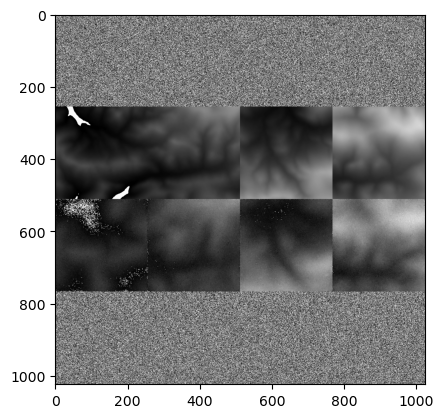

In [28]:
#cur_log_folder = "tb_logs/debug_UNet_train2noise_1kTrainIter/version_2"
chpt_files = f"{cur_log_folder}/checkpoints/*.ckpt"
chpt_files = sorted(glob.glob(chpt_files))
chpt_f = chpt_files[-1]
print(chpt_f)
model = TerGenUNet.load_from_checkpoint(chpt_f)
model.cpu()
model.eval()


debug_loader = torch.utils.data.DataLoader(ds, batch_size=4, shuffle=False)
inp = next(iter(debug_loader))

with torch.no_grad(): # no need for gradients on input data
    bs = inp.shape[0]
    noise = torch.randn(inp.shape, device = inp.device)

    # random number of inferences to perform on each image
    # inference_amounts = torch.randint(0, model.n_inferences, (bs,),
    #                          device=inp.device, dtype=torch.int64)
    inference_amounts = torch.full((bs,), model.n_iter_train*0.5, dtype=torch.int64)
    
    noised_inp = model.noise_scheduler.add_noise(inp, noise, inference_amounts)

    out = model.forward(noised_inp, inference_amounts)
    pred_original = model.noise_scheduler.single_iter_predict_original(out, inference_amounts, noised_inp)

    inp_imgs = [v2.functional.to_pil_image(invTrans(inp[i,:,:])) for i in range(bs)]
    noised_imgs = [v2.functional.to_pil_image(invTrans(noised_inp[i,:,:])) for i in range(bs)]
    pred_noise = [v2.functional.to_pil_image(invTrans(out[i,:,:])) for i in range(bs)]
    denoised_imgs = [v2.functional.to_pil_image(invTrans(pred_original[i,:,:])) for i in range(bs)]

imgs = noised_imgs + inp_imgs + denoised_imgs + pred_noise
image_grid = make_image_grid(imgs, rows=4, cols=bs)

plt.imshow(image_grid)
plt.show()

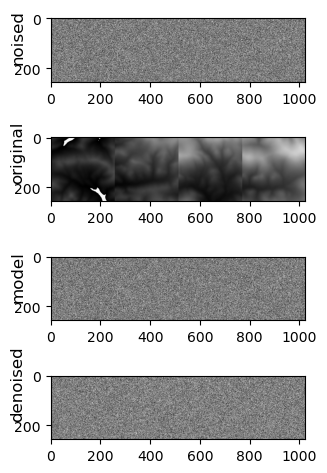

In [29]:
debug_loader = torch.utils.data.DataLoader(ds, batch_size=4, shuffle=False)
inp = next(iter(debug_loader))

with torch.no_grad(): # no need for gradients on input data
    bs = inp.shape[0]
    noise = torch.randn(inp.shape, device = inp.device)

    # Pull back noise to fully random
    inference_amounts = torch.full((bs,), model.n_iter_train-1,
                             device=inp.device, dtype=torch.int64)
    
    noised_inp = model.noise_scheduler.add_noise(inp, noise, inference_amounts)

    out = model.forward(noised_inp, inference_amounts)
    pred_original = model.noise_scheduler.single_iter_predict_original(out, inference_amounts, noised_inp)

    inp_imgs = [v2.functional.to_pil_image(invTrans(inp[i,:,:])) for i in range(bs)]
    noised_imgs = [v2.functional.to_pil_image(invTrans(noised_inp[i,:,:])) for i in range(bs)]
    out_imgs = [v2.functional.to_pil_image(invTrans(out[i,:,:])) for i in range(bs)]
    denoised_imgs = [v2.functional.to_pil_image(invTrans(pred_original[i,:,:])) for i in range(bs)]
    

plt.subplot(411)
plt.imshow(make_image_grid(noised_imgs, rows=1, cols=bs))
plt.title("noised", x=-0.13, y=0.2, rotation = 90)

plt.subplot(412)
plt.imshow(make_image_grid(inp_imgs, rows=1, cols=bs))
plt.title("original", x=-0.13, y=0.2, rotation = 90)

plt.subplot(413)
plt.imshow(make_image_grid(out_imgs, rows=1, cols=bs))
plt.title("model", x=-0.13, y=0.2, rotation = 90)

plt.subplot(414)
plt.imshow(make_image_grid(denoised_imgs, rows=1, cols=bs))
plt.title("denoised", x=-0.13, y=0.2, rotation = 90)

plt.tight_layout()

plt.savefig(os.path.join(cur_log_folder, "samples", "final_chkpt_DS_examples.png"), bbox_inches='tight')
plt.show()

# Generate images for LinkedIn article

In [38]:
chpt_f = 'tb_logs/UNet_train2noise_1kTrainIter/version_2/checkpoints/epoch=000046-val_MSE_epoch=0.0031.ckpt'
model = TerGenUNet.load_from_checkpoint(chpt_f)
model.cuda()
model.eval()

n_samples = 12
outs = invTrans(model.sample(n_samples, seed=6987135))
norm_outs =invTrans(outs).detach().cpu()

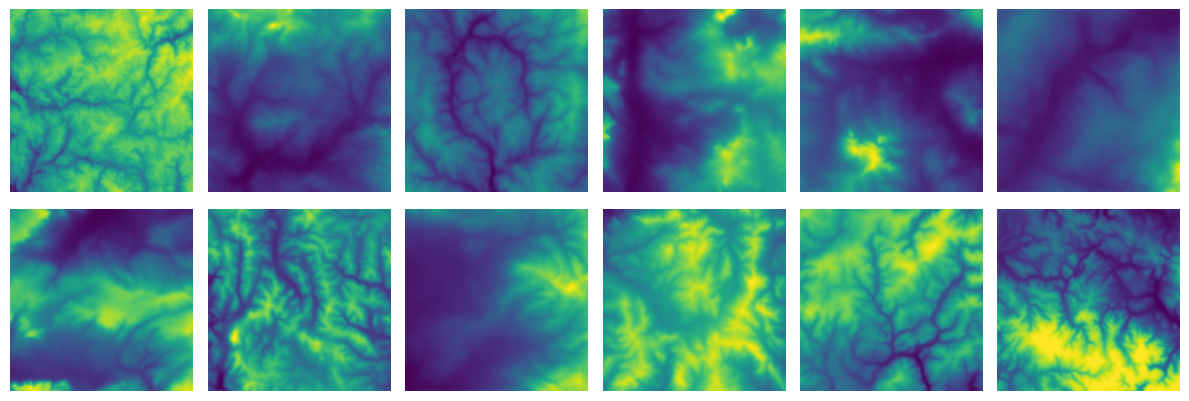

In [39]:
fig, axs = plt.subplots(2, int(n_samples/2), sharex="all", sharey="all",
                        figsize=[12, 4.5], layout="tight")
for i in range(n_samples):
    x = i % int(n_samples/2)
    y = int(i/int(n_samples/2))
    axs[y,x].imshow(norm_outs[i,0,:,:].numpy())
    axs[y,x].set_box_aspect(1)
    axs[y,x].set_axis_off()

plt.savefig("Generated.png", transparent=True)
plt.show()

## Header

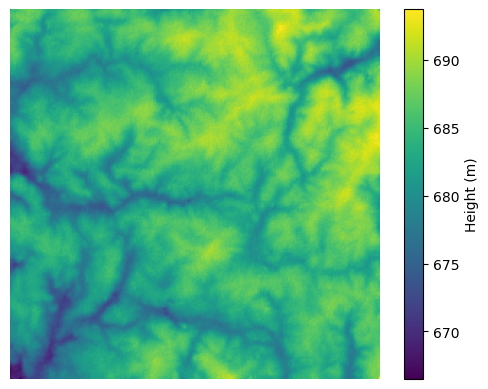

In [43]:
plt.imshow(norm_outs[0,0,:,:].numpy()*2000.)
plt.gca().set_box_aspect(1)
plt.gca().set_axis_off()

plt.colorbar(label="Height (m)")

plt.savefig("Header.png", transparent=True)
plt.show()

## training example

In [83]:
debug_loader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=True)
inp = next(iter(debug_loader)).to(model.device)

with torch.no_grad(): # no need for gradients on input data
    bs = inp.shape[0]
    noise = torch.randn(inp.shape, device = inp.device)

    model.noise_scheduler.set_timesteps(model.n_iter_train)
    inference_amounts = torch.full((bs,), model.n_iter_train*0.08, dtype=torch.int64, device=inp.device)
    
    noised_inp = model.noise_scheduler.add_noise(inp, noise, inference_amounts)

    out = model.forward(noised_inp, inference_amounts)
    pred_original = model.noise_scheduler.single_iter_predict_original(out, inference_amounts, noised_inp)

    inp_imgs = [v2.functional.to_pil_image(invTrans(inp[i,:,:])) for i in range(bs)]
    noised_imgs = [v2.functional.to_pil_image(invTrans(noised_inp[i,:,:])) for i in range(bs)]
    pred_noise = [v2.functional.to_pil_image(invTrans(out[i,:,:])) for i in range(bs)]
    denoised_imgs = [v2.functional.to_pil_image(invTrans(pred_original[i,:,:])) for i in range(bs)]

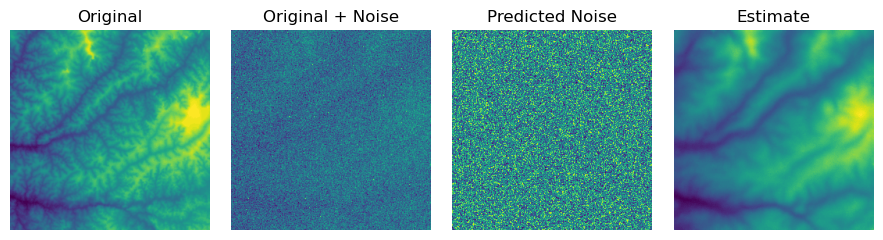

In [84]:
fig, axs = plt.subplots(1,4,
                        figsize=[9, 2.5], layout="tight")

axs[0].imshow(inp_imgs[0])
axs[0].set_box_aspect(1)
axs[0].set_axis_off()
axs[0].set_title("Original")

axs[1].imshow(noised_imgs[0])
axs[1].set_box_aspect(1)
axs[1].set_axis_off()
axs[1].set_title("Original + Noise")

axs[2].imshow(pred_noise[0])
axs[2].set_box_aspect(1)
axs[2].set_axis_off()
axs[2].set_title("Predicted Noise")

axs[3].imshow(denoised_imgs[0])
axs[3].set_box_aspect(1)
axs[3].set_axis_off()
axs[3].set_title("Estimate")

plt.savefig("Training.png", transparent=True)
plt.show()

## Generation progress

In [144]:
N=1
images = torch.randn((N, 1, model.tile_size, model.tile_size),
                      device = model.device)    

noise = images.detach().cpu().numpy()[0,0,:,:]
estimates = []
# predictions = []

# set step values
model.noise_scheduler.set_timesteps(model.n_inferences)

for t in model.noise_scheduler.timesteps:
    # 1. predict noise model_output
    model_output = model.unet(images, t).sample.detach()

    # 2. compute previous image: x_t -> t_t-1
    images = model.noise_scheduler.step(model_output, t, images).prev_sample

    # predictions.append(invTrans(model_output[0,:,:,:]).detach().cpu().numpy()[0,:,:])
    estimates.append(invTrans(images[0,:,:,:]).detach().cpu().numpy()[0,:,:])

del images

/tmp/ipykernel_207/3666528230.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("Progress.png", transparent=True, bbox_inches='tight')


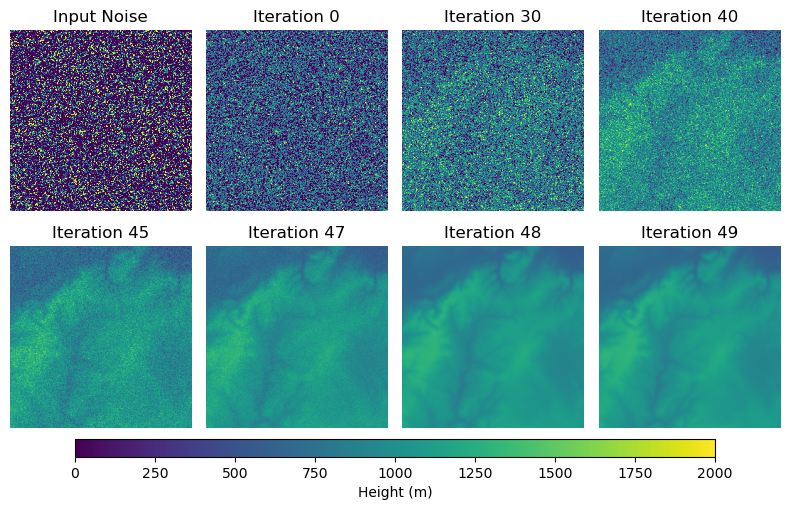

In [146]:

arr = ["noise", 0,30,40,45,47,48,49]
n_horiz = int(len(arr)/2)
fig, axs = plt.subplots(2, n_horiz, sharex="all", sharey="all",
                        figsize=[8, 6], layout="tight")
for i in range(len(arr)):
    x = i % n_horiz
    y = int(i/n_horiz)

    if(arr[i]=="noise"):
        img = noise
        axs[y,x].set_title("Input Noise")
    else:
        img = estimates[arr[i]]
        axs[y,x].set_title(f"Iteration {arr[i]}")
    
    im = axs[y,x].imshow(img*2000, vmin=0, vmax=2000)
    axs[y,x].set_box_aspect(1)
    axs[y,x].set_axis_off()

plt.subplots_adjust(hspace=-0.5)

cbar_ax = fig.add_axes([0.1, 0.12, 0.80, 0.03])
plt.colorbar(im, label="Height (m)", orientation="horizontal", cax=cbar_ax)
plt.savefig("Progress.png", transparent=True, bbox_inches='tight')
plt.show()

# Profile the memory consumption for deployment

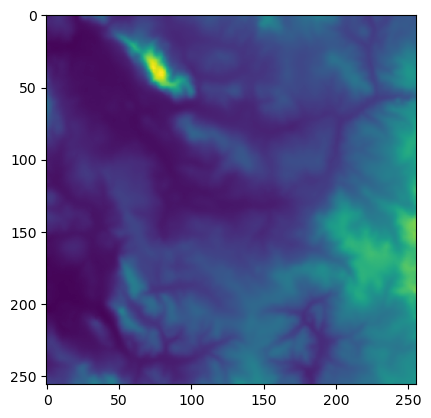

In [8]:
from torch.profiler import profile, record_function, ProfilerActivity
import glob

# cur_log_folder = "tb_logs/UNet_train2noise_1kTrainIter/version_2"
# chpt_files = f"{cur_log_folder}/checkpoints/*.ckpt"
# chpt_files = sorted(glob.glob(chpt_files))
# print(chpt_files)

chpt_f = 'tb_logs/UNet_train2noise_1kTrainIter/version_2/checkpoints/epoch=000046-val_MSE_epoch=0.0031.ckpt'
model = TerGenUNet.load_from_checkpoint(chpt_f)
model.cpu()
model.eval()

with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        outs = invTrans(model.sample(4, seed=69871354))

plt.imshow(outs[0,0,:,:])
plt.show()

In [9]:
print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          aten::empty         0.23%      45.010ms         0.23%      45.010ms       1.800us      18.22 Gb      18.22 Gb         25004  
                                   aten::_convolution         0.10%      19.737ms        17.61%        3.479s     869.754us       7.97 Gb    -231.61 Mb          4000  
                                         aten::conv2d         0.05%       9.597ms        17.73%        3.503s     875.632us       7.97 Gb           0 b         

In [12]:
# print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

This is too large for the server. Most memory is consumed by attention. Try a deeper network with attention only at end.
# Profile more compact untrained neetwork architecture

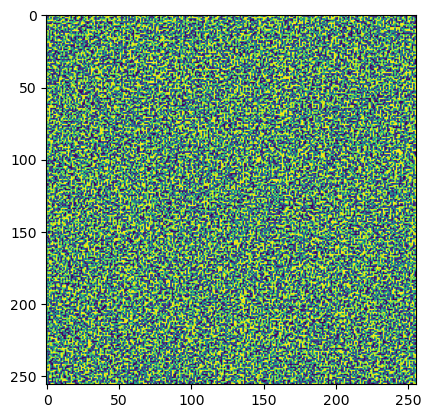

-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          aten::empty         1.75%      12.399ms         1.75%      12.399ms       0.611us       1.21 Gb       1.21 Gb         20304  
                                         aten::conv2d         0.89%       6.326ms        46.57%     330.442ms      66.756us     413.09 Mb           0 b          4950  
                                    aten::convolution         1.26%       8.953ms        45.68%     324.117ms      65.478us     413.09 Mb           0 b         

In [8]:
UNetMicro_blocks = (
    (
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        #"AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        
    ),
    (
        #"AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    (1, 2, 4, 8, 16, 32)
)

down_block_types, up_block_types, block_out_channels = UNetMicro_blocks
model = TerGenUNet(tile_size=256,  n_inferences=50, n_iter_train=1000,
                           down_block_types = down_block_types,
                           up_block_types=up_block_types,
                           block_out_channels = block_out_channels,
                           norm_num_groups=1,
                           attention_head_dim=2,
                           )
model.cpu()
model.eval()

from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        outs = invTrans(model.sample(1, seed=69871354))

plt.imshow(outs[0,0,:,:])
plt.show()
print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

In [9]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      model_inference        26.61%     188.821ms       100.00%     709.606ms     709.606ms     256.00 Kb      -1.78 Gb             1  
                                         aten::conv2d         0.89%       6.326ms        46.57%     330.442ms      66.756us     413.09 Mb           0 b          4950  
                                    aten::convolution         1.26%       8.953ms        45.68%     324.117ms      65.478us     413.09 Mb           0 b         

In [10]:
from torchview import draw_graph
inference_amounts = torch.full((1,), model.n_iter_train*0.5, dtype=torch.int64, device='meta')
# model.forward(torch.randn((1,1,256,256),device='meta'), inference_amounts)
model_graph = draw_graph(model, input_data=[torch.randn((1,1,256,256)), inference_amounts], device='meta',
                        roll=True,    hide_inner_tensors=False, hide_module_functions=False,
                        expand_nested=True, depth=2)
model_graph.visual_graph
model_graph.visual_graph.render("graphname", format="png")

'graphname.png'

# convert to ONNX

In [24]:
model = TerGenUNet(tile_size=256,  n_inferences=50, n_iter_train=1000,
                           down_block_types = down_block_types,
                           up_block_types=up_block_types,
                           block_out_channels = block_out_channels,
                           norm_num_groups=1,
                           attention_head_dim=2,
                           )
model.cpu()
model.eval()

# inference wrapper
class SamplingWrapper(L.LightningModule):
    def __init__(self, model=None, *args, **kwargs):
        super().__init__()
        if(model is not None):
            self.model = model
        else:
            self.model = TerGenUNet(*args, **kwargs)

    def forward(self, N=1):
        """Call the underlying model's sample function for one image."""
        return self.model.sample(N, use_default_gen=True)[:,0,:,:]

wraper = SamplingWrapper(model)
filepath = "UNetMicro_untrained.onnx"
wraper.to_onnx(filepath, input_sample=torch.tensor([1], dtype=torch.int64), export_params=True)


/tmp/ipykernel_12805/1752479691.py:120: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for t in self.noise_scheduler.timesteps:
/home/zetadin/miniconda3/envs/lightning/lib/python3.11/site-packages/torch/onnx/_internal/jit_utils.py:314: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789121465/work/torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
/home/zetadin/miniconda3/envs/lightning/lib/python3.11/site-packages/torch/onnx/utils.py:739: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789121465/work/torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
/home/zet

In [25]:
import onnxruntime
ort_session = onnxruntime.InferenceSession(filepath)
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: np.array([1])}
ort_outs = ort_session.run(None, ort_inputs)
print(ort_outs.shape)

2024-09-11 12:14:13.680553320 [W:onnxruntime:, graph.cc:109 MergeShapeInfo] Error merging shape info for output. '/unet/time_proj/Cos_output_0' source:{-1,1} target:{-1,0}. Falling back to lenient merge.
2024-09-11 12:14:13.680947896 [W:onnxruntime:, graph.cc:109 MergeShapeInfo] Error merging shape info for output. '/unet/time_proj/Sin_output_0' source:{-1,1} target:{-1,0}. Falling back to lenient merge.
2024-09-11 12:14:13.682526371 [W:onnxruntime:, graph.cc:109 MergeShapeInfo] Error merging shape info for output. '/unet/time_proj_1/Cos_output_0' source:{-1,1} target:{-1,0}. Falling back to lenient merge.
2024-09-11 12:14:13.682532863 [W:onnxruntime:, graph.cc:109 MergeShapeInfo] Error merging shape info for output. '/unet/time_proj_1/Sin_output_0' source:{-1,1} target:{-1,0}. Falling back to lenient merge.
2024-09-11 12:14:13.684013422 [W:onnxruntime:, graph.cc:109 MergeShapeInfo] Error merging shape info for output. '/unet/time_proj_2/Cos_output_0' source:{-1,1} target:{-1,0}. Falli

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Non-zero status code returned while running Gemm node. Name:'/unet/time_embedding/linear_1/Gemm' Status Message: GEMM: Dimension mismatch, W: {4,1} K: 3 N:4